sampled 30 experts

randomly selected experts for CM comparison:
Expert Id: 4, Group: 1
Expert Id: 26, Group: 2
Expert Id: 30, Group: 3
Round 1 Median: 10.56%, Standard deviation: 11.06%
Round 2 Median: 10.56%, Standard deviation: 7.74%
Round 3 Median: 10.56%, Standard deviation: 6.19%

randomly selected experts for DM comparison:
Expert Id: 27, Group: 2
Expert Id: 2, Group: 1
Expert Id: 20, Group: 2
Expert Id: 13, Group: 1
Expert Id: 4, Group: 1

STATISTICAL SUMMARY TABLE
     Comparisons  number of comparions  significant distinctions(p<0.05) mean p-value min p-value
expert vs expert                   435                                 1       0.4445      0.0469
    expert vs CM                     3                                 0       0.3658      0.0636
    expert vs DM                     5                                 0       0.5752      0.1000


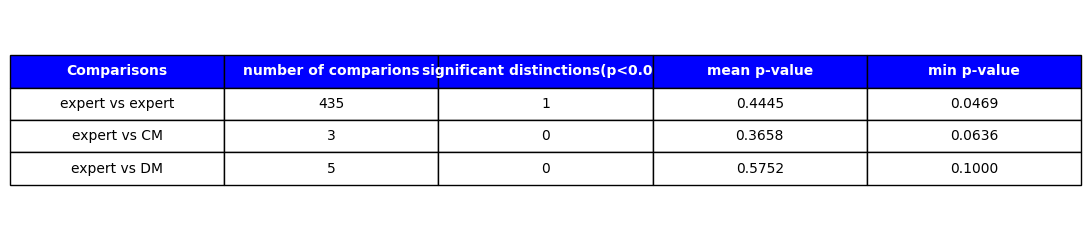


SPREAD ANALYSIS TABLE
                   Method Spread (%)
Average Individual Expert      17.24
            Cooke's Model      13.17
            Delphi Method      15.14


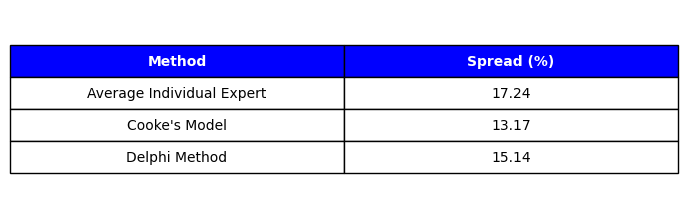


CM IREP Forecast Table
   Quantile Cooke's Model IREP Forecast (%)
Pessimistic                            2.67
     Median                            8.98
 Optimistic                           15.84

DM IREP Forecast Table
   Quantile Delphi Method IREP Forecast (%)
Pessimistic                            4.05
     Median                           10.56
 Optimistic                           19.19


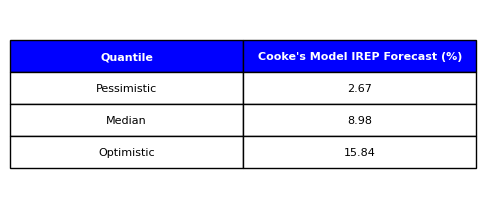

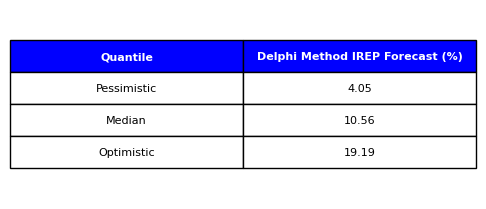

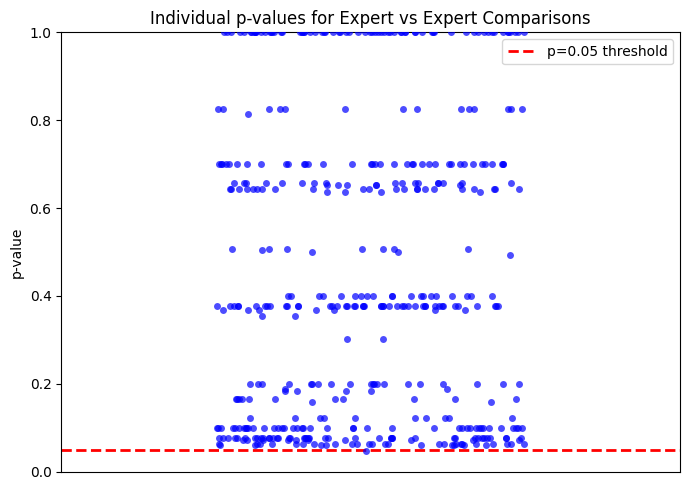

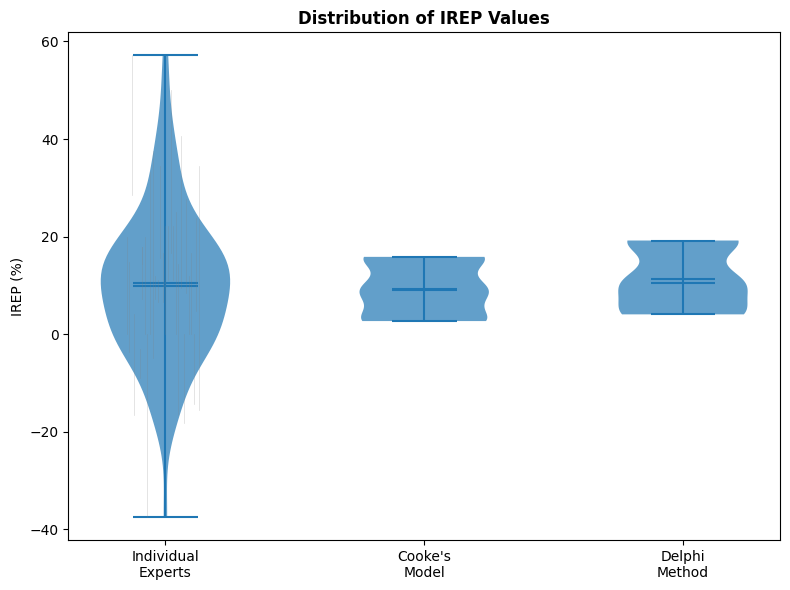

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sb

dataset=pd.read_excel("41560_2021_810_MOESM3_ESM.xlsx", sheet_name="data")

complete_data = dataset[
    (dataset['onshore_2019_cf'].notna()) & 
    (dataset['onshore_2035_low_cf'].notna()) & 
    (dataset['onshore_2035_median_cf'].notna()) & 
    (dataset['onshore_2035_high_cf'].notna()) #filter for existing data
].copy()

#key metric calculation
complete_data['irep_optimistic'] = ((complete_data['onshore_2035_low_cf']-complete_data['onshore_2019_cf']) /complete_data['onshore_2019_cf'] *100)
complete_data['irep_median'] = ((complete_data['onshore_2035_median_cf']-complete_data['onshore_2019_cf']) /complete_data['onshore_2019_cf'] *100)
complete_data['irep_pessimistic'] = ((complete_data['onshore_2035_high_cf']-complete_data['onshore_2019_cf']) /complete_data['onshore_2019_cf'] *100)

expertise_map = {
    'Wind energy markets and/or cost analysis': 1,
    'Systems­-level wind technologies, focused on the entire wind turbine and/or wind plant': 2,
    'Subsystem-level wind technologies, focused on specific wind turbine and/or wind plant subsystems or components': 3 #map the groups 1-3
}
complete_data['expertise_code'] = complete_data['expertise_type'].map(expertise_map)

#sample 30 experts by type
selected_experts =[]
rs= len(complete_data)-45
for exp_type, n_sample in [(1, 16), (2, 12), (3, 2)]:
    type_experts = complete_data[complete_data['expertise_code'] == exp_type]
    sampled = type_experts.sample(n=min(n_sample, len(type_experts)), random_state=rs)
    selected_experts.append(sampled)

experts_df = pd.concat(selected_experts).reset_index(drop=True)
experts_df['expert_id'] = range(1, 31)
print(f"sampled {len(experts_df)} experts")

expert_ireps = {}
for i, row in experts_df.iterrows():
    expert_ireps[row['expert_id']] = [row['irep_pessimistic'], row['irep_median'], row['irep_optimistic']]

#compare expert to expert
pairwise_results = []
for expert1, expert2 in combinations(range(1, 31), 2):
    values1 = expert_ireps[expert1]
    values2 = expert_ireps[expert2]
    stat, pval = stats.mannwhitneyu(values1, values2, alternative='two-sided')
    pairwise_results.append({
        'expert1': expert1,
        'expert2': expert2,
        'pvalue': pval,
        'significant': pval < 0.05
    })
results_df = pd.DataFrame(pairwise_results)
n_significant = results_df['significant'].sum()

#CM simulation
calibration_scores = {1: 0.6, 2: 0.7, 3: 0.5}
weights =[]
for i, expert in experts_df.iterrows():
    cal_score = calibration_scores[expert['expertise_code']]
    spread =expert['irep_optimistic'] - expert['irep_pessimistic']
    median_spread = (experts_df['irep_optimistic'] - experts_df['irep_pessimistic']).median()
    info_score = 1/(1 + abs(spread)/abs(median_spread))
    weight=cal_score*info_score
    weights.append(weight)
weights = np.array(weights)
weights = weights /weights.sum()
cm_pessimistic=sum(experts_df['irep_pessimistic'] *weights)
cm_median=sum(experts_df['irep_median'] *weights)
cm_optimistic=sum(experts_df['irep_optimistic'] *weights)
cm_values = [cm_pessimistic, cm_median, cm_optimistic]

#3 experts to CM
cm_comparison_experts = []
print("\nrandomly selected experts for CM comparison:")
for exp_type in [1, 2, 3]:
    type_experts = experts_df[experts_df['expertise_code'] == exp_type]
    selected = type_experts.sample(n=1) 
    expert_id = selected['expert_id'].iloc[0]
    cm_comparison_experts.append(expert_id)
    print(f"Expert Id: {expert_id}, Group: {exp_type}")

#DM simulation
delphi_values = experts_df[['expert_id', 'irep_pessimistic', 'irep_median', 'irep_optimistic']].copy()
for round_num in range(1, 4):
    round_median = delphi_values['irep_median'].median()
    round_std = delphi_values['irep_median'].std()
    print(f"Round {round_num} Median: {round_median:.2f}%, Standard deviation: {round_std:.2f}%")
    if round_num < 3:
        adjustment_factor = 0.3 if round_num == 1 else 0.2
        next_round = delphi_values.copy()
        for i in delphi_values.index:
            current_median = delphi_values.loc[i, 'irep_median']
            adjustment = (round_median - current_median) *adjustment_factor
            next_round.loc[i, 'irep_pessimistic'] = delphi_values.loc[i, 'irep_pessimistic'] + adjustment
            next_round.loc[i, 'irep_median'] = delphi_values.loc[i, 'irep_median'] + adjustment
            next_round.loc[i, 'irep_optimistic'] = delphi_values.loc[i, 'irep_optimistic'] + adjustment
        delphi_values = next_round

dm_pessimistic = delphi_values['irep_pessimistic'].median()
dm_median = delphi_values['irep_median'].median()
dm_optimistic = delphi_values['irep_optimistic'].median()
dm_values = [dm_pessimistic, dm_median, dm_optimistic]

#DM comparison
random_experts = experts_df.sample(n=5)['expert_id'].tolist()
print("\nrandomly selected experts for DM comparison:")
for expert_id in random_experts:
    group = experts_df[experts_df['expert_id'] == expert_id]['expertise_code'].iloc[0]
    print(f"Expert Id: {expert_id}, Group: {group}")
#statistical summary
expert_vs_expert_pvalues = results_df['pvalue'].values
n_sig_expert_vs_expert = (results_df['pvalue'] < 0.05).sum()

cm_vs_expert_pvalues = []
for expert_id in cm_comparison_experts:
    expert_values = expert_ireps[expert_id]
    stat, pval = stats.mannwhitneyu(cm_values, expert_values, alternative='two-sided')
    cm_vs_expert_pvalues.append(pval)
n_sig_cm_vs_expert = sum(np.array(cm_vs_expert_pvalues) < 0.05)

dm_vs_expert_pvalues = []
for expert_id in random_experts:
    expert_values = expert_ireps[expert_id]
    stat, pval = stats.mannwhitneyu(dm_values, expert_values, alternative='two-sided')
    dm_vs_expert_pvalues.append(pval)
n_sig_dm_vs_expert = sum(np.array(dm_vs_expert_pvalues) < 0.05)

summary_data = {
    "Comparisons": [
        "expert vs expert",
        "expert vs CM",
        "expert vs DM"
    ],
    "number of comparions": [
        len(expert_vs_expert_pvalues),
        len(cm_vs_expert_pvalues),
        len(dm_vs_expert_pvalues)
    ],
    "significant distinctions(p<0.05)": [
        n_sig_expert_vs_expert,
        n_sig_cm_vs_expert,
        n_sig_dm_vs_expert
    ],
    "mean p-value": [
        f"{np.mean(expert_vs_expert_pvalues):.4f}",
        f"{np.mean(cm_vs_expert_pvalues):.4f}",
        f"{np.mean(dm_vs_expert_pvalues):.4f}"
    ],
    "min p-value": [
        f"{np.min(expert_vs_expert_pvalues):.4f}",
        f"{np.min(cm_vs_expert_pvalues):.4f}",
        f"{np.min(dm_vs_expert_pvalues):.4f}"
    ]
}
summary_df = pd.DataFrame(summary_data)
print("\nSTATISTICAL SUMMARY TABLE")
print(summary_df.to_string(index=False))

#plot visualizations
fig, ax = plt.subplots(figsize=(11, 2.5))
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.25, 1.7)
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('blue')
    table[(0, i)].set_text_props(weight='bold', color='white')
plt.tight_layout() 
#plt.savefig('statistical_summary.png', dpi=300, bbox_inches='tight') #uncomment to save
plt.show()

#spread analysis table
avg_individual_spread = (experts_df['irep_optimistic'] - experts_df['irep_pessimistic']).mean()
cm_spread = cm_optimistic - cm_pessimistic
dm_spread = dm_optimistic - dm_pessimistic

spread_data = {
    'Method': [
        'Average Individual Expert',
        "Cooke's Model",
        'Delphi Method'
    ],
    'Spread (%)': [
        f"{avg_individual_spread:.2f}",
        f"{cm_spread:.2f}",
        f"{dm_spread:.2f}"
    ]
}
spread_df = pd.DataFrame(spread_data)
print("\nSPREAD ANALYSIS TABLE")

print(spread_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(7,2.3))
ax.axis('off')
table = ax.table(
    cellText=spread_df.values,
    colLabels=spread_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.25, 1.7)
for i in range(len(spread_df.columns)):
    table[(0, i)].set_facecolor('blue')
    table[(0, i)].set_text_props(weight='bold', color='white')
plt.tight_layout()
#plt.savefig('spread_analysis.png', dpi=300, bbox_inches='tight') #uncomment to save it as png if you want
plt.show()

#irep forecast for cm and dm
cm_irep_data = {
    'Quantile': ['Pessimistic', 'Median', 'Optimistic'],
    "Cooke's Model IREP Forecast (%)": [
        f"{cm_pessimistic:.2f}",
        f"{cm_median:.2f}",
        f"{cm_optimistic:.2f}"
    ]
}
dm_irep_data = {
    'Quantile': ['Pessimistic', 'Median', 'Optimistic'],
    "Delphi Method IREP Forecast (%)": [
        f"{dm_pessimistic:.2f}",
        f"{dm_median:.2f}",
        f"{dm_optimistic:.2f}"
    ]
}
cm_irep_df=pd.DataFrame(cm_irep_data)
dm_irep_df=pd.DataFrame(dm_irep_data)

print("\nCM IREP Forecast Table")
print(cm_irep_df.to_string(index=False))

print("\nDM IREP Forecast Table")
print(dm_irep_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(5,2.2))
ax.axis('off')
table = ax.table(
    cellText=cm_irep_df.values,
    colLabels=cm_irep_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.25, 1.7)
for i in range(len(cm_irep_df.columns)):
    table[(0, i)].set_facecolor('blue')
    table[(0, i)].set_text_props(weight='bold', color='white')
plt.tight_layout()
#plt.savefig('cm_irep_forecast.png', dpi=300, bbox_inches='tight') #uncomment to save it as png if you want
plt.show()

fig, ax = plt.subplots(figsize=(5,2.2))
ax.axis('off')
table= ax.table(
    cellText=dm_irep_df.values,
    colLabels=dm_irep_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.25, 1.7)
for i in range(len(dm_irep_df.columns)):
    table[(0, i)].set_facecolor('blue')
    table[(0, i)].set_text_props(weight='bold', color='white')
plt.tight_layout()
#plt.savefig('dm_irep_forecast.png', dpi=300, bbox_inches='tight') #uncomment to save it as png if you want
plt.show()

#expert vs expert plot
fig, ax = plt.subplots(figsize=(7,5))
sb.stripplot(y=results_df['pvalue'], color='blue', alpha=0.7, ax=ax, size=5, jitter=0.25)
ax.axhline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
ax.set_ylabel('p-value')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_title('Individual p-values for Expert vs Expert Comparisons')
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
#plt.savefig('expert_vs_expert_pvalues_strip.png', dpi=300, bbox_inches='tight') #uncomment to save it as png if you want
plt.show()

#distribution of IREP values plot
all_individual_values = []
for expert_id in expert_ireps:
    all_individual_values.extend(expert_ireps[expert_id])

positions = [1, 2, 3]
violin_data =[all_individual_values, cm_values * 10, dm_values * 10]
fig, ax = plt.subplots(figsize=(8, 6))
parts = ax.violinplot(violin_data, positions=positions, showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_alpha(0.7)
for i, expert_id in enumerate(expert_ireps):
    values = expert_ireps[expert_id]
    ax.plot([0.85 + i*0.01]*3, values, 'gray', alpha=0.3, linewidth=0.5)
ax.set_xticks(positions)
ax.set_xticklabels(['Individual\nExperts', 'Cooke\'s\nModel', 'Delphi\nMethod'])
ax.set_ylabel('IREP (%)')
ax.set_title('Distribution of IREP Values', fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig('distribution_of_IREP_values.png', dpi=300, bbox_inches='tight') #uncomment to save it as png if you want
plt.show()

